In [2]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

### INSTALATIONS

In [1]:
%pip install -U datasets==2.17.0 torch==1.13.1 torchdata==0.5.1 transformers==4.27.2 evaluate==0.4.0 rouge_score==0.1.2 loralib==0.1.1 peft==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 14.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 766.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 416.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00:00:01

In [3]:

data = "knkarthick/dialogsum"
dt = load_dataset(data)


Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


## Dataset size and columns available 

In [4]:
dt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

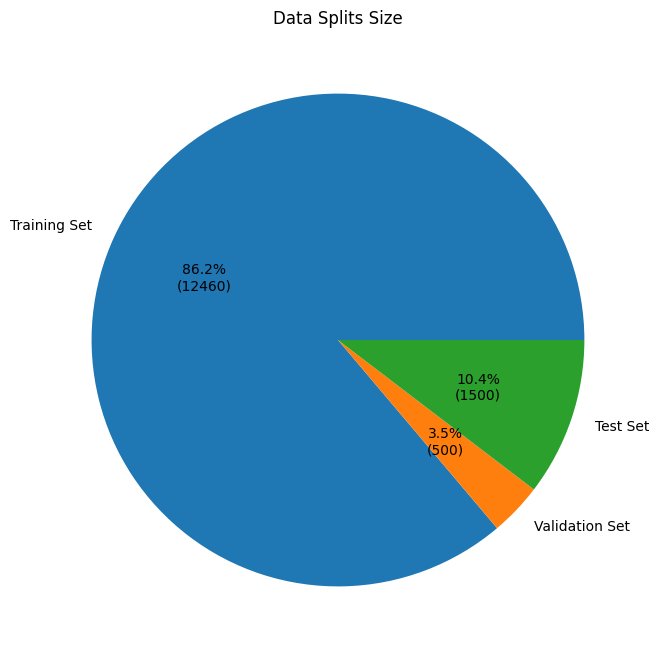

In [5]:
ds = [12460, 500, 1500]
lb = ['Training Set', 'Validation Set', 'Test Set']
def cal(p, a):
    ab = int(p/100.*sum(a))
    return "{:.1f}%\n({:d})".format(p, ab)
plt.figure(figsize=(8, 8))
plt.pie(ds, labels=lb, autopct=lambda pct: cal(pct, ds))
plt.title('Data Splits Size')
plt.show()

In [6]:
train_df = pd.DataFrame(dt['train'])
validation_df = pd.DataFrame(dt['validation'])
test_df = pd.DataFrame(dt['test'])

## Looking at Data

In [7]:
train_df.head()

,id,dialogue,summary,topic
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance


In [8]:
print(train_df['dialogue'][0])

#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks doctor.


In [9]:
print(train_df['summary'][0])

Mr. Smith's getting a check-up, and Doctor Hawkins advises him to have one every year. Hawkins'll give some information about their classes and medications to help Mr. Smith quit smoking.


## Dropping unnecessary column for our training 

In [10]:
train_df.drop('topic',axis=1,inplace=True)
validation_df.drop('topic',axis=1,inplace=True)
test_df.drop('topic',axis=1,inplace=True)

In [11]:
train_df.head(5)

,id,dialogue,summary
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw..."
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...


In [12]:
og = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base', torch_dtype=torch.bfloat16)
tk = AutoTokenizer.from_pretrained('google/flan-t5-base')

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [13]:
a = "My name is aman"
en = tk(a)
s = tk.decode(
        en["input_ids"][0])
print(s)
print(en)

2024-06-29 15:40:27.771583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 15:40:27.771683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 15:40:27.897274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


My
{'input_ids': [499, 564, 19, 3, 9, 348, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


## Lets test some random prompts

In [14]:
#https://huggingface.co/docs/transformers/en/model_doc/flan-t5

In [15]:
p="Write an essay about India"
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}")
print(f"Response: {re}\n")

Prompt: Write an essay about India
Response: India is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of hist

In [16]:
p="Summarize this in 1 lines: India is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country"
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}\n")
print(f"Response: {re}\n")

Prompt: Summarize this in 1 lines: India is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and culture. It is a country with a lot of history and cu

### Trying different prompt styles for the model

In [17]:
p="summarize  \n" + train_df['dialogue'][30]
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}")
print(f"Response: {re}\n")
print("original summary "+train_df['summary'][30])

Prompt: summarize  
#Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
Response: #Person1#: We're going to take the steak dinner.

original summary #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.


In [18]:

p="Explain whats happening  \n" + train_df['dialogue'][30]
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}")
print(f"Response: {re}\n")
print("original summary "+train_df['summary'][30])

Prompt: Explain whats happening  
#Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.
Response: The restaurant is full.

original summary #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.


In [19]:
p="Summarize the conversation\n" + train_df['dialogue'][30]
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}\n")
print(f"Response: {re}\n")
print("original summary "+train_df['summary'][30])

Prompt: Summarize the conversation
#Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little longer?
#Person1#: Yes, take your time, please.
#Person2#: Can we get something to drink? We want two bottles of beer.
#Person1#: Fine.
#Person2#: Could you tell us your specials today?
#Person1#: The special today is steak.
#Person2#: We'll take this steak dinner.
#Person1#: What would you like to go with your steak?
#Person2#: Peas and carrots.
#Person1#: I see. What would you like for dessert?
#Person2#: Icecream, please.

Response: The steak dinner will be served at 7:00 pm.

original summary #Person1# serves #Person2# to order two bottles of beer, a steak dinner, and ice cream.


### Lets try one shot inference method 

In [20]:
p="Summarize the conversation\n"+train_df['dialogue'][200] + "\nSummary:" + train_df['summary'][200] +"\n\nSummarize the conversation\n"+ train_df['dialogue'][30] 
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}\n")
print(f"Response: {re}\n")
print("original summary "+train_df['summary'][30])

Prompt: Summarize the conversation
#Person1#: What do you want to know about me?
#Person2#: How about your academic records at college?
#Person1#: The average grade of all my courses is above 85.
#Person2#: In which subject did you get the highest marks?
#Person1#: In mathematics I got a 98.
#Person2#: Have you received any scholarships?
#Person1#: Yes, I have, and three times in total.
#Person2#: Have you been a class leader?
#Person1#: I have been a class commissary in charge of studies for two years.
#Person2#: Did you join in any club activities?
#Person1#: I was an aerobics team member in college.
#Person2#: What sport are you good at?
#Person1#: I am good at sprint and table tennis.
#Person2#: You are excellent.
Summary:#Person2# asks #Person1# several questions, like academic records, the highest marks, scholarships, club activities, and skilled sports.

Summarize the conversation
#Person1#: May I take your order?
#Person2#: We haven't decided yet. Could you give us a little lon

### Try fewshot prompting 

In [21]:
a=""
for i in ([2,44,66,111]):
    a=a+"Summarize the conversation\n"+train_df['dialogue'][i] + "\nSummary:" + train_df['summary'][i]+"\n\n"

In [22]:
p=a+"\n\nSummarize the conversation\n"+ train_df['dialogue'][30] 
ip = tk(p, return_tensors="pt")
ot = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}\n")
print(f"Response: {re}\n")
print("original summary "+train_df['summary'][30])

Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 512). Running this sequence through the model will result in indexing errors


Prompt: Summarize the conversation
#Person1#: Excuse me, did you see a set of keys?
#Person2#: What kind of keys?
#Person1#: Five keys and a small foot ornament.
#Person2#: What a shame! I didn't see them.
#Person1#: Well, can you help me look for it? That's my first time here.
#Person2#: Sure. It's my pleasure. I'd like to help you look for the missing keys.
#Person1#: It's very kind of you.
#Person2#: It's not a big deal.Hey, I found them.
#Person1#: Oh, thank God! I don't know how to thank you, guys.
#Person2#: You're welcome.
Summary:#Person1#'s looking for a set of keys and asks for #Person2#'s help to find them.

Summarize the conversation
#Person1#: Next week is your birthday party. How exciting! What do you want for your birthday?
#Person2#: Well, a car like yours would be fantastic.
#Person1#: Hmm...Maybe not a car just yet. You're only turning 9, you know? How about a doll?
#Person2#: Mom, I'm a boy. Boys don't play with stupid dolls, but a machine gun would be OK, too.
#Pers

### So now lets try to fine tune the model to give better results by PEFT

#### before going forward lets test base models score

In [14]:
#rd_f = test_df.sample(n=10, random_state=1)
ds = test_df['dialogue']
hm = test_df['summary']

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
og.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [23]:
os = []
for i, j in enumerate(ds):
    p = "Summarize the conversation\n" + j
    ip = tk(p, return_tensors="pt").to(device)

    ogo = og.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
    re = tk.decode(ogo[0], skip_special_tokens=True)

    os.append(re)
df = pd.DataFrame({
    'human summaries': hm,
    'model summary': os
})

df

Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors


,human summaries,model summary
0,Ms. Dawson helps #Person1# to write a memo to ...,The following memo is to be distributed to all...
1,In order to prevent employees from wasting tim...,The following memo is to be distributed to all...
2,Ms. Dawson takes a dictation for #Person1# abo...,The following memo is to be distributed to all...
3,#Person2# arrives late because of traffic jam....,The traffic jam at the Carrefour intersection ...
4,#Person2# decides to follow #Person1#'s sugges...,The traffic jam at the Carrefour intersection ...
...,...,...
1495,Matthew and Steve meet after a long time. Stev...,"#Person1#: Hi, Steve."
1496,Steve has been looking for a place to live. Ma...,"#Person1#: Hi, Steve."
1497,Frank invites Besty to the party to celebrate ...,Person1 is going to throw a party for all of h...
1498,Frank invites Betsy to the big promotion party...,Person1 is going to throw a party for all of h...


In [24]:
import evaluate
r = evaluate.load('rouge')
ore = r.compute(
    predictions=df['model summary'].tolist(),
    references=df['human summaries'].tolist(),
    use_aggregator=True,
    use_stemmer=True,
)

print(ore)

{'rouge1': 0.2248748468148314, 'rouge2': 0.06455773069170524, 'rougeL': 0.19279672363512235, 'rougeLsum': 0.192602292931872}


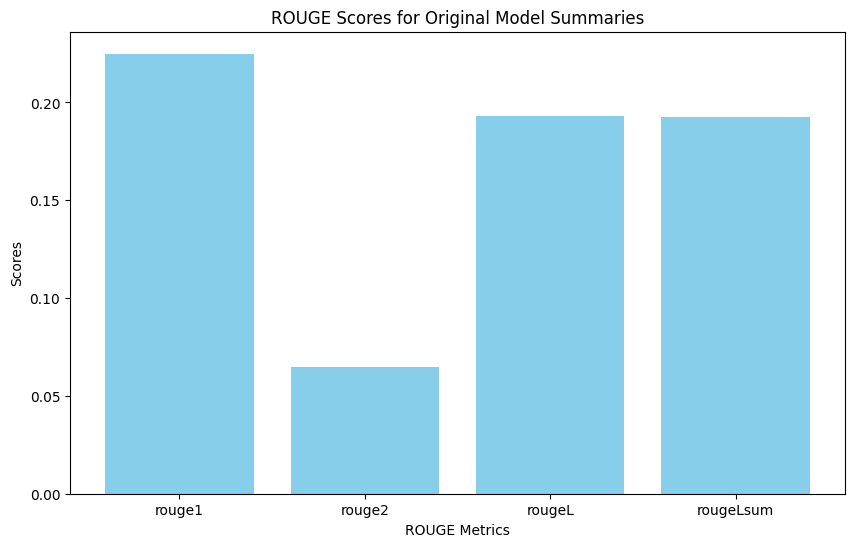

In [25]:
import matplotlib.pyplot as plt
metrics = list(ore.keys())
scores = list(ore.values())
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores for Original Model Summaries')
plt.show()

### Beginning the training process

In [16]:
import wandb
wandb.init(project="LORA")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
from peft import LoraConfig, get_peft_model, TaskType
congfi = LoraConfig(
    r=16, 
    lora_alpha=16,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM 
)

In [29]:
pm = get_peft_model(og, congfi)
tp = sum(p.numel() for p in pm.parameters() if p.requires_grad)
ttp = sum(p.numel() for p in pm.parameters())
print("For PEFT MODEL usign LORA",tp)
print("Percentage of Trainable Parameters:", 100 * tp / ttp)

For PEFT MODEL usign LORA 1769472
Percentage of Trainable Parameters: 0.7096414524241463


In [30]:
from transformers import Trainer, TrainingArguments
trg = TrainingArguments(
    output_dir='./op',  
    auto_find_batch_size=True,
    learning_rate=1e-3,  
    num_train_epochs=10,
    logging_steps=500,
    report_to="wandb"
     
)

In [31]:
from datasets import Dataset
def fun(dtt):
    ip = ["Summarize the conversation\n" + dialogue for dialogue in dtt['dialogue']]
    mp = tk(ip, truncation=True, padding="max_length")
    with tk.as_target_tokenizer():
        labels = tk(dtt['summary'], truncation=True, padding="max_length")
    mp["labels"] = labels["input_ids"]
    return mp

Dat = Dataset.from_pandas(train_df)
dt_tk = Dat.map(fun, batched=True)
dt_tk_t = dt_tk

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [32]:
d = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(d)


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

#### TRAINING

In [33]:
tr = Trainer(
    model=pm,
    args=trg,
    train_dataset=dt_tk,
)

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='transformers.optimization')
tr.train()

Step,Training Loss
500,1.834500
1000,0.126700
1500,0.118000
2000,0.112000
2500,0.111000
3000,0.106900
3500,0.103400
4000,0.104200
4500,0.102500
5000,0.099700


TrainOutput(global_step=15580, training_loss=0.15302278374217748, metrics={'train_runtime': 19269.2209, 'train_samples_per_second': 6.466, 'train_steps_per_second': 0.809, 'total_flos': 8.59980690358272e+16, 'train_loss': 0.15302278374217748, 'epoch': 10.0})

### SAVING AND EVALUATING MODEL

In [37]:
tr.model.save_pretrained("./peft-dialogue")
tk.save_pretrained("./peft-dialogue")

('./peft-dialogue/tokenizer_config.json',
 './peft-dialogue/special_tokens_map.json',
 './peft-dialogue/spiece.model',
 './peft-dialogue/added_tokens.json',
 './peft-dialogue/tokenizer.json')

In [38]:
import shutil
shutil.make_archive("peft-dialogue", 'zip', "./peft-dialogue")

'/kaggle/working/peft-dialogue.zip'

In [39]:
from IPython.display import FileLink
FileLink(r'peft-dialogue.zip')

/kaggle/working/peft-dialogue.zip

In [18]:
from peft import PeftModel
tk = AutoTokenizer.from_pretrained("/kaggle/input/peft-dialogue")
pm = PeftModel.from_pretrained(og, "/kaggle/input/peft-dialogue")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(device)


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

### ROUGH FOR PEFT MODEL ON TEST DATA

In [46]:
ds = test_df['dialogue']
hm = test_df['summary']

os = []
for i, j in enumerate(ds):
    p = "Summarize the conversation\n" + j
    ip = tk(p, return_tensors="pt").to(device)
    ogo = pm.model.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
    re = tk.decode(ogo[0], skip_special_tokens=True)

    os.append(re)
df = pd.DataFrame({
    'human summaries': hm,
    'model summary': os
})


Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors


In [47]:

rouge = evaluate.load('rouge')
ore = rouge.compute(
    predictions=df['model summary'].tolist(),
    references=df['human summaries'].tolist(),
    use_aggregator=True,
    use_stemmer=True,
)

print(ore)


{'rouge1': 0.4534539494105222, 'rouge2': 0.19174333083749437, 'rougeL': 0.36820616832548786, 'rougeLsum': 0.36823502596311425}


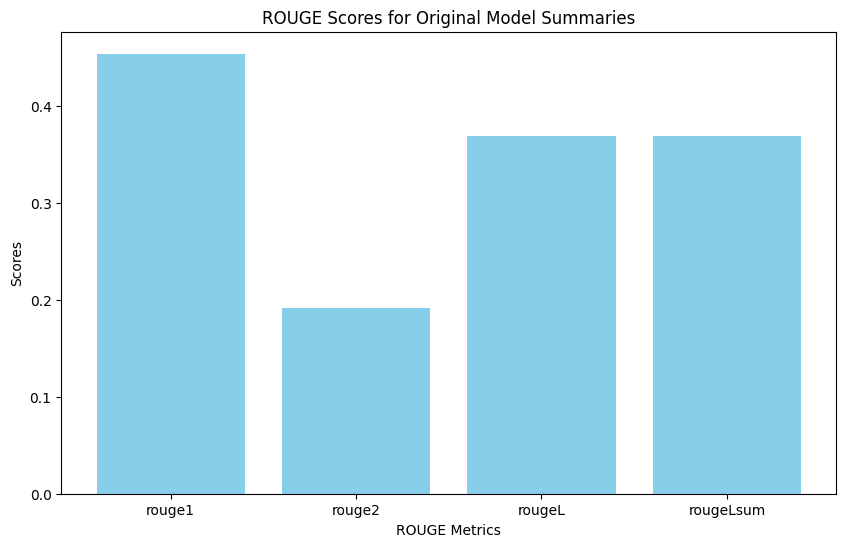

In [48]:
import matplotlib.pyplot as plt
metrics = list(ore.keys())
scores = list(ore.values())
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores for Original Model Summaries')
plt.show()

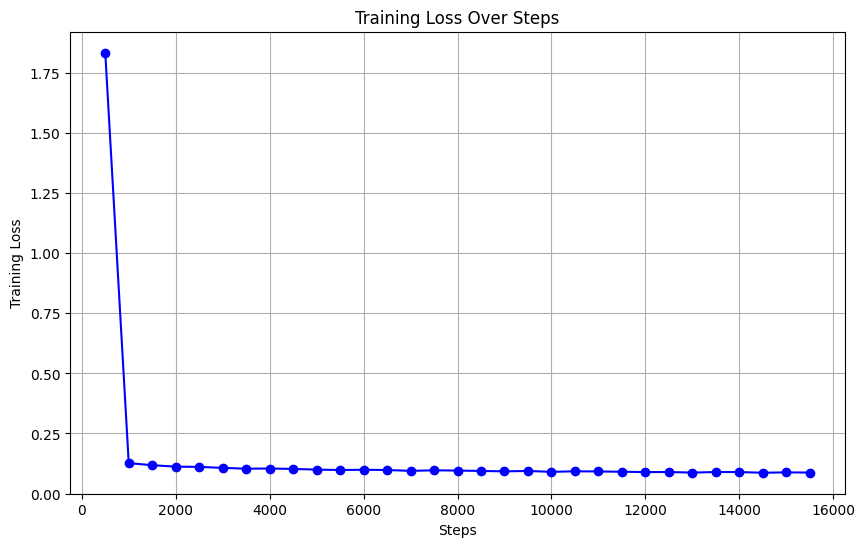

In [26]:
import matplotlib.pyplot as plt

steps = [
    500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
    5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000,
    10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000,
    15500
]

training_loss = [
    1.834500, 0.126700, 0.118000, 0.112000, 0.111000, 0.106900, 0.103400, 0.104200, 0.102500, 0.099700,
    0.098000, 0.099000, 0.098000, 0.094400, 0.096700, 0.095700, 0.094100, 0.092400, 0.094000, 0.090300,
    0.092700, 0.091900, 0.090800, 0.089400, 0.089600, 0.087200, 0.089600, 0.089400, 0.086700, 0.088100,
    0.087400
]

plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

### RESULTS COMPARISION 

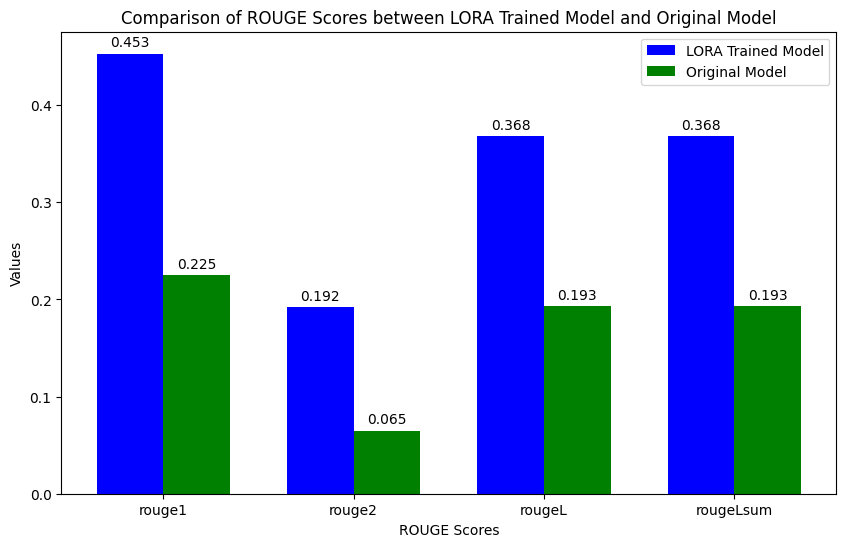

In [28]:
import numpy as np

l_scores = {
    'rouge1': 0.453,
    'rouge2': 0.192,
    'rougeL': 0.368,
    'rougeLsum': 0.368
}

o_scores = {
    'rouge1': 0.225,
    'rouge2': 0.065,
    'rougeL': 0.193,
    'rougeLsum': 0.193
}

labels = list(l_scores.keys())
l_vals = list(l_scores.values())
o_vals = list(o_scores.values())

x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
r1 = ax.bar(x - w/2, l_vals, w, label='LORA Trained Model', color='b')
r2 = ax.bar(x + w/2, o_vals, w, label='Original Model', color='g')

ax.set_xlabel('ROUGE Scores')
ax.set_ylabel('Values')
ax.set_title('Comparison of ROUGE Scores between LORA Trained Model and Original Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def annotate_bars(rects):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(f'{h:.3f}', xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

annotate_bars(r1)
annotate_bars(r2)

plt.show()

In [16]:
from peft import PeftModel
tk = AutoTokenizer.from_pretrained("/kaggle/input/peft-dialogue")
pm = PeftModel.from_pretrained(og, "/kaggle/input/peft-dialogue")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(device)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

In [19]:
p="summarize  \n" + test_df['dialogue'][30]
ip = tk(p, return_tensors="pt").to(device)
ot = pm.model.generate(ip["input_ids"], max_length=300, num_return_sequences=1)
re = tk.decode(ot[0], skip_special_tokens=True)
print(f"Prompt: {p}")
print(f"Response: {re}\n")
print("original summary "+test_df['summary'][30])

2024-06-22 19:09:05.689364: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 19:09:05.689504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 19:09:05.822822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Prompt: summarize  
#Person1#: Where are you going for your trip?
#Person2#: I think Hebei is a good place.
#Person1#: But I heard the north of China are experiencing severe sandstorms!
#Person2#: Really?
#Person1#: Yes, it's said that Hebes was experiencing six degree strong winds.
#Person2#: How do these storms affect the people who live in these areas?
#Person1#: The report said the number of people with respiratory tract infections tended to rise after sandstorms. The sand gets into people's noses and throats and creates irritation.
#Person2#: It sounds that sandstorms are trouble for everybody!
#Person1#: You are quite right.
Response: #Person2#'s going to Hebei for a trip. #Person1# tells #Person2# the north of China is experiencing severe sandstorms. #Person2# thinks sandstorms are trouble for everybody.

original summary #Person2# plans to have a trip in Hebei but #Person1# says there are sandstorms in there.


In [17]:
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/lvwerra/trl.git (to revision 25fa1bd) to /tmp/pip-req-build-o58_955m
  Running command git clone --filter=blob:none --quiet https://github.com/lvwerra/trl.git /tmp/pip-req-build-o58_955m
  Running command git checkout -q 25fa1bd
  Resolved https://github.com/lvwerra/trl.git to commit 25fa1bd
  Preparing metadata (setup.py) ... done
  Created wheel for trl: filename=trl-0.4.2.dev0-py3-none-any.whl size=67532 sha256=f84dec44e29c263f1c879d7fdfced442317030ce96cac86384107d0c04f20d52
  Stored in directory: /tmp/pip-ephem-wheel-cache-17fvpfy6/wheels/24/b4/20/2fa3a1e47c0411c39e198029315e3af2a2c1d59132913f136f
Successfully built trl
Note: you may need to restart the kernel to use updated packages.


### RLHF TRAINING PROCESS BEGINS 

In [20]:
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead, create_reference_model
from trl.core import LengthSampler

In [ ]:
from peft import PeftModel
tk = AutoTokenizer.from_pretrained("/kaggle/input/peft-dialogue")
pm = PeftModel.from_pretrained(og, "/kaggle/input/peft-dialogue")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(device)

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tox_tk = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
tox_mdl = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target").to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [23]:
import numpy as np
from tqdm import tqdm
def eval_tox(md, tox_mdl, tox_tk, ds):
    max_toks = 300
    tox_scores = []
    max_seq_len = tox_tk.model_max_length
    for i, dlg in tqdm(enumerate(ds)):
        ip = tk(f"Summarize the conversation\n{dlg}", return_tensors="pt").to(device)
        gen_ids = md.model.generate(ip["input_ids"], max_length=max_toks)
        gen_txt = tk.decode(gen_ids[0], skip_special_tokens=True)

        full_txt = dlg + " " + gen_txt
        tox_ip_ids = tox_tk(full_txt, truncation=True,max_length=max_seq_len,return_tensors="pt").input_ids.to(device)
        logits = tox_mdl(tox_ip_ids).logits
        probs = logits.softmax(dim=-1).tolist()[0]
        tox_score = probs[1]  

        tox_scores.append(tox_score)

    mean_tox = np.mean(tox_scores)
    std_tox = np.std(tox_scores)
    
    return mean_tox, std_tox

ds = test_df['dialogue']
mean_tox, std_tox = eval_tox(pm, tox_mdl, tox_tk, ds)
print(f'Toxicity [mean, std]: [{mean_tox}, {std_tox}]')

261it [04:28,  1.11s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors
1500it [26:36,  1.06s/it]

Toxicity [mean, std]: [0.028158942559879507, 0.08178810660198951]


In [ ]:
##Training LLM on RLHF

In [61]:
og = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base', torch_dtype=torch.bfloat16)
tk = AutoTokenizer.from_pretrained('google/flan-t5-base')

In [62]:
from peft import PeftModel
peft_model_path = "/kaggle/input/peft-dialogue"
pm = PeftModel.from_pretrained(og, peft_model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(device)

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(
                    in_features=768, out_features=768, bias=False
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
                    (lora_embedding_B):

In [63]:
from trl import AutoModelForSeq2SeqLMWithValueHead
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(pm, torch_dtype=torch.bfloat16, is_trainable=True)

In [64]:
from trl import create_reference_model
ref_model = create_reference_model(ppo_model)

In [65]:
tp = sum(p.numel() for p in ppo_model.parameters() if p.requires_grad)
ttp = sum(p.numel() for p in ppo_model.parameters())
print("For PPO Model using PEFT")
print("Trainable Parameters:", tp)
print("Total Parameters:", ttp)
print("Percentage of Trainable Parameters:", 100 * tp / ttp)

For PPO Model using PEFT
Trainable Parameters: 769
Total Parameters: 249348097
Percentage of Trainable Parameters: 0.00030840419848882983


In [66]:
def collator(data):
    return {"input_ids": torch.stack([torch.tensor(item["input_ids"]) for item in data])}
def tokenize_function(examples):
    pps = ["Summarize the conversation\n" + dialogue for dialogue in examples["dialogue"]]
    return tk(pps, truncation=True, padding="max_length", max_length=512)

In [67]:
data = Dataset.from_pandas(train_df)
from datasets import Dataset
tkdt = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

### TRAINING PROCESS BEGINS

In [68]:
from trl import PPOConfig, PPOTrainer
config = PPOConfig(
    model_name='google/flan-t5-base',
    learning_rate=3e-5,        
    ppo_epochs=10,               
    mini_batch_size=16,         
    batch_size=64,                        
    log_with="wandb"
)


ppo_trainer = PPOTrainer(
    config=config,
    model=ppo_model,
    ref_model=ref_model,
    tokenizer=tk,
    dataset=tkdt,
    data_collator=collator
)

In [69]:
from transformers import pipeline
from tqdm import tqdm

In [70]:
from trl.core import LengthSampler
ols = LengthSampler(100, 400)

In [71]:
Smp = pipeline(
    "sentiment-analysis", 
    model="facebook/roberta-hate-speech-dynabench-r4-target", 
    framework="pt",
    device=0 if torch.cuda.is_available() else "cpu"
)

In [72]:
generation_kwargs = {
    "min_length": 10,     
    "top_k": 10,           
    "top_p": 0.92,         
    "do_sample": True      }

In [73]:
reward_kwargs = {
    "top_k": None,                  
    "function_to_apply": "none",    
    "batch_size": 16               
}

### TRAINING

In [79]:
max_s = 500
nhi =0
for s, b in tqdm(enumerate(ppo_trainer.dataloader)):
    if s >= max_s:
        break
    pts = [pt for pt in b["input_ids"]]
    st = []  
    for pt in pts:
        max_nt = ols()  
        generation_kwargs["max_new_tokens"] = max_nt
        sm = ppo_trainer.generate(pt, **generation_kwargs) 
        st.append(sm.squeeze()[-max_nt:])
    b["response"] = [tk.decode(r.squeeze()) for r in st]
    qrp = [tk.decode(q) + r for q, r in zip(b["input_ids"], b["response"])]  
    qrp= [seq[:512] for seq in qrp]
    rws = Smp(qrp, **reward_kwargs)  
    rt = [torch.tensor(rw[nhi]["score"]) for rw in rws]
    bc = {"query": [tk.decode(q) for q in b["input_ids"]], "response": b["response"]}
    sts = ppo_trainer.step(pts, st, rt) 
    ppo_trainer.log_stats(sts, bc, rt)
    wandb.log({
        "objective/kl": sts["objective/kl"],
        "ppo/returns/mean": sts["ppo/returns/mean"],
        "ppo/policy/advantages_mean": sts["ppo/policy/advantages_mean"],
        "step": s
    })

    print(f'objective/kl: {sts["objective/kl"]}')
    print(f'ppo/returns/mean: {sts["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {sts["ppo/policy/advantages_mean"]}')
    print('-' * 100)
wandb.finish()

1it [01:45, 105.31s/it]

objective/kl: 46.1929931640625
ppo/returns/mean: [-1.248247]
ppo/policy/advantages_mean: [7.208205e-09]
----------------------------------------------------------------------------------------------------


2it [03:19, 98.80s/it] 

objective/kl: 39.26350402832031
ppo/returns/mean: [-1.0034271]
ppo/policy/advantages_mean: [8.865982e-10]
----------------------------------------------------------------------------------------------------


3it [05:16, 107.28s/it]

objective/kl: 51.50603485107422
ppo/returns/mean: [-1.4902967]
ppo/policy/advantages_mean: [3.0859635e-09]
----------------------------------------------------------------------------------------------------


4it [07:01, 106.06s/it]

objective/kl: 46.66033935546875
ppo/returns/mean: [-1.3579469]
ppo/policy/advantages_mean: [4.960833e-09]
----------------------------------------------------------------------------------------------------


5it [08:41, 104.17s/it]

objective/kl: 43.70137023925781
ppo/returns/mean: [-1.2475946]
ppo/policy/advantages_mean: [3.217474e-09]
----------------------------------------------------------------------------------------------------


6it [10:20, 102.25s/it]

objective/kl: 45.576847076416016
ppo/returns/mean: [-1.4231033]
ppo/policy/advantages_mean: [-2.882819e-09]
----------------------------------------------------------------------------------------------------


7it [11:59, 101.26s/it]

objective/kl: 40.33234786987305
ppo/returns/mean: [-1.240242]
ppo/policy/advantages_mean: [1.6384043e-09]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
8it [13:43, 101.97s/it]

objective/kl: 44.80738067626953
ppo/returns/mean: [-1.5329615]
ppo/policy/advantages_mean: [1.6272498e-09]
----------------------------------------------------------------------------------------------------


9it [15:23, 101.53s/it]

objective/kl: 44.212059020996094
ppo/returns/mean: [-1.4953781]
ppo/policy/advantages_mean: [-2.2495505e-09]
----------------------------------------------------------------------------------------------------


10it [17:14, 104.42s/it]

objective/kl: 47.51875686645508
ppo/returns/mean: [-1.6107887]
ppo/policy/advantages_mean: [-3.6803045e-09]
----------------------------------------------------------------------------------------------------


11it [19:00, 104.99s/it]

objective/kl: 46.961605072021484
ppo/returns/mean: [-1.7611862]
ppo/policy/advantages_mean: [-4.146188e-09]
----------------------------------------------------------------------------------------------------


12it [20:40, 103.30s/it]

objective/kl: 43.417964935302734
ppo/returns/mean: [-1.4899721]
ppo/policy/advantages_mean: [1.3271346e-09]
----------------------------------------------------------------------------------------------------


13it [22:20, 102.49s/it]

objective/kl: 44.92052459716797
ppo/returns/mean: [-1.7672482]
ppo/policy/advantages_mean: [-1.2232249e-09]
----------------------------------------------------------------------------------------------------


14it [24:08, 103.97s/it]

objective/kl: 48.478553771972656
ppo/returns/mean: [-1.9703087]
ppo/policy/advantages_mean: [7.771752e-09]
----------------------------------------------------------------------------------------------------


15it [26:02, 107.12s/it]

objective/kl: 49.78874588012695
ppo/returns/mean: [-1.978937]
ppo/policy/advantages_mean: [1.3276827e-09]
----------------------------------------------------------------------------------------------------


16it [27:50, 107.16s/it]

objective/kl: 46.095638275146484
ppo/returns/mean: [-1.987593]
ppo/policy/advantages_mean: [-1.6726279e-09]
----------------------------------------------------------------------------------------------------


17it [29:25, 103.55s/it]

objective/kl: 42.9332275390625
ppo/returns/mean: [-1.8892425]
ppo/policy/advantages_mean: [-1.4109788e-09]
----------------------------------------------------------------------------------------------------


18it [31:02, 101.73s/it]

objective/kl: 41.40123748779297
ppo/returns/mean: [-1.694018]
ppo/policy/advantages_mean: [1.1600133e-09]
----------------------------------------------------------------------------------------------------


19it [32:43, 101.59s/it]

objective/kl: 45.614280700683594
ppo/returns/mean: [-2.0389097]
ppo/policy/advantages_mean: [-5.5520637e-09]
----------------------------------------------------------------------------------------------------


20it [34:25, 101.54s/it]

objective/kl: 44.4090576171875
ppo/returns/mean: [-1.9037716]
ppo/policy/advantages_mean: [-2.9198584e-09]
----------------------------------------------------------------------------------------------------


21it [36:04, 100.91s/it]

objective/kl: 44.35310363769531
ppo/returns/mean: [-1.8486302]
ppo/policy/advantages_mean: [-8.6724315e-11]
----------------------------------------------------------------------------------------------------


22it [37:50, 102.21s/it]

objective/kl: 45.2106819152832
ppo/returns/mean: [-2.0179617]
ppo/policy/advantages_mean: [-9.935749e-10]
----------------------------------------------------------------------------------------------------


23it [39:36, 103.59s/it]

objective/kl: 47.62041473388672
ppo/returns/mean: [-2.1272085]
ppo/policy/advantages_mean: [-1.3877806e-09]
----------------------------------------------------------------------------------------------------


24it [41:13, 101.37s/it]

objective/kl: 41.2906379699707
ppo/returns/mean: [-1.8970855]
ppo/policy/advantages_mean: [8.320081e-10]
----------------------------------------------------------------------------------------------------


25it [42:57, 102.26s/it]

objective/kl: 47.76048278808594
ppo/returns/mean: [-2.2127838]
ppo/policy/advantages_mean: [1.0304689e-09]
----------------------------------------------------------------------------------------------------


26it [44:46, 104.19s/it]

objective/kl: 44.23925018310547
ppo/returns/mean: [-1.9248631]
ppo/policy/advantages_mean: [-2.5311784e-09]
----------------------------------------------------------------------------------------------------


27it [46:30, 104.20s/it]

objective/kl: 45.078155517578125
ppo/returns/mean: [-2.037887]
ppo/policy/advantages_mean: [2.3210265e-09]
----------------------------------------------------------------------------------------------------


28it [48:10, 103.04s/it]

objective/kl: 43.365352630615234
ppo/returns/mean: [-2.069674]
ppo/policy/advantages_mean: [-7.4712103e-10]
----------------------------------------------------------------------------------------------------


29it [49:52, 102.79s/it]

objective/kl: 43.32463073730469
ppo/returns/mean: [-1.9984677]
ppo/policy/advantages_mean: [-2.1291726e-09]
----------------------------------------------------------------------------------------------------


30it [51:34, 102.49s/it]

objective/kl: 46.18092346191406
ppo/returns/mean: [-2.279287]
ppo/policy/advantages_mean: [-6.6478284e-10]
----------------------------------------------------------------------------------------------------


31it [53:19, 103.20s/it]

objective/kl: 45.529048919677734
ppo/returns/mean: [-2.234198]
ppo/policy/advantages_mean: [-1.5952527e-09]
----------------------------------------------------------------------------------------------------


32it [54:58, 102.03s/it]

objective/kl: 40.63550567626953
ppo/returns/mean: [-1.9422349]
ppo/policy/advantages_mean: [-1.4417483e-09]
----------------------------------------------------------------------------------------------------


33it [56:36, 100.70s/it]

objective/kl: 44.38597106933594
ppo/returns/mean: [-2.095506]
ppo/policy/advantages_mean: [-1.6789151e-09]
----------------------------------------------------------------------------------------------------


34it [58:19, 101.41s/it]

objective/kl: 44.2947998046875
ppo/returns/mean: [-2.158015]
ppo/policy/advantages_mean: [-1.0769312e-09]
----------------------------------------------------------------------------------------------------


35it [1:00:12, 104.90s/it]

objective/kl: 47.489471435546875
ppo/returns/mean: [-2.3327973]
ppo/policy/advantages_mean: [1.656281e-09]
----------------------------------------------------------------------------------------------------


36it [1:01:54, 104.04s/it]

objective/kl: 41.74046325683594
ppo/returns/mean: [-1.9931576]
ppo/policy/advantages_mean: [2.0028006e-10]
----------------------------------------------------------------------------------------------------


37it [1:03:41, 104.81s/it]

objective/kl: 45.39963150024414
ppo/returns/mean: [-2.181116]
ppo/policy/advantages_mean: [-4.689315e-10]
----------------------------------------------------------------------------------------------------


38it [1:05:26, 104.88s/it]

objective/kl: 46.0620231628418
ppo/returns/mean: [-2.4707272]
ppo/policy/advantages_mean: [-1.8716838e-10]
----------------------------------------------------------------------------------------------------


39it [1:07:04, 102.84s/it]

objective/kl: 42.29264831542969
ppo/returns/mean: [-2.130905]
ppo/policy/advantages_mean: [-5.5026583e-10]
----------------------------------------------------------------------------------------------------


40it [1:08:45, 102.37s/it]

objective/kl: 43.28458786010742
ppo/returns/mean: [-2.1874802]
ppo/policy/advantages_mean: [-2.6944713e-10]
----------------------------------------------------------------------------------------------------


41it [1:10:23, 100.95s/it]

objective/kl: 45.27394104003906
ppo/returns/mean: [-2.3206494]
ppo/policy/advantages_mean: [3.360183e-10]
----------------------------------------------------------------------------------------------------


42it [1:11:58, 99.33s/it] 

objective/kl: 40.69149398803711
ppo/returns/mean: [-2.1594913]
ppo/policy/advantages_mean: [-3.849574e-09]
----------------------------------------------------------------------------------------------------


43it [1:13:37, 99.10s/it]

objective/kl: 42.490501403808594
ppo/returns/mean: [-2.1069314]
ppo/policy/advantages_mean: [2.4068354e-09]
----------------------------------------------------------------------------------------------------


44it [1:15:14, 98.39s/it]

objective/kl: 40.80034637451172
ppo/returns/mean: [-2.054736]
ppo/policy/advantages_mean: [-1.7933939e-10]
----------------------------------------------------------------------------------------------------


45it [1:16:44, 96.13s/it]

objective/kl: 40.631736755371094
ppo/returns/mean: [-2.1521602]
ppo/policy/advantages_mean: [-1.4612473e-09]
----------------------------------------------------------------------------------------------------


46it [1:18:20, 96.05s/it]

objective/kl: 42.67881393432617
ppo/returns/mean: [-2.2012594]
ppo/policy/advantages_mean: [-3.6416254e-09]
----------------------------------------------------------------------------------------------------


47it [1:19:58, 96.70s/it]

objective/kl: 43.280704498291016
ppo/returns/mean: [-2.2653005]
ppo/policy/advantages_mean: [-2.1709585e-09]
----------------------------------------------------------------------------------------------------


48it [1:21:39, 97.90s/it]

objective/kl: 46.75255584716797
ppo/returns/mean: [-2.6017418]
ppo/policy/advantages_mean: [-4.3481374e-09]
----------------------------------------------------------------------------------------------------


49it [1:23:12, 96.51s/it]

objective/kl: 41.67500305175781
ppo/returns/mean: [-2.3850048]
ppo/policy/advantages_mean: [-1.4412452e-09]
----------------------------------------------------------------------------------------------------


50it [1:24:52, 97.40s/it]

objective/kl: 42.80695343017578
ppo/returns/mean: [-2.390937]
ppo/policy/advantages_mean: [-3.2752853e-10]
----------------------------------------------------------------------------------------------------


51it [1:26:32, 98.15s/it]

objective/kl: 43.473968505859375
ppo/returns/mean: [-2.3775978]
ppo/policy/advantages_mean: [-3.9487688e-10]
----------------------------------------------------------------------------------------------------


52it [1:28:19, 100.76s/it]

objective/kl: 45.29935073852539
ppo/returns/mean: [-2.4455736]
ppo/policy/advantages_mean: [2.068086e-09]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -104.41 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
53it [1:29:59, 100.58s/it]

objective/kl: -104.41354370117188
ppo/returns/mean: [9.817229]
ppo/policy/advantages_mean: [6.2347283e-10]
----------------------------------------------------------------------------------------------------


54it [1:31:42, 101.44s/it]

objective/kl: 46.90965270996094
ppo/returns/mean: [-2.630547]
ppo/policy/advantages_mean: [-2.3061715e-09]
----------------------------------------------------------------------------------------------------


55it [1:33:35, 104.72s/it]

objective/kl: 49.715248107910156
ppo/returns/mean: [-2.6821423]
ppo/policy/advantages_mean: [-1.211939e-09]
----------------------------------------------------------------------------------------------------


56it [1:35:10, 102.01s/it]

objective/kl: 41.9543571472168
ppo/returns/mean: [-2.390391]
ppo/policy/advantages_mean: [-1.1923367e-09]
----------------------------------------------------------------------------------------------------


57it [1:36:52, 102.00s/it]

objective/kl: 45.1628303527832
ppo/returns/mean: [-2.462496]
ppo/policy/advantages_mean: [1.6087335e-09]
----------------------------------------------------------------------------------------------------


58it [1:38:34, 102.05s/it]

objective/kl: 46.64837646484375
ppo/returns/mean: [-2.5986454]
ppo/policy/advantages_mean: [1.9864637e-09]
----------------------------------------------------------------------------------------------------


59it [1:40:18, 102.45s/it]

objective/kl: 44.397647857666016
ppo/returns/mean: [-2.5896862]
ppo/policy/advantages_mean: [2.05982e-10]
----------------------------------------------------------------------------------------------------


60it [1:41:53, 100.30s/it]

objective/kl: 41.087074279785156
ppo/returns/mean: [-2.4441612]
ppo/policy/advantages_mean: [5.062697e-10]
----------------------------------------------------------------------------------------------------


61it [1:43:45, 103.82s/it]

objective/kl: 49.69673156738281
ppo/returns/mean: [-2.8143117]
ppo/policy/advantages_mean: [2.2451303e-09]
----------------------------------------------------------------------------------------------------


62it [1:45:25, 102.59s/it]

objective/kl: 42.33798599243164
ppo/returns/mean: [-2.4134533]
ppo/policy/advantages_mean: [2.6346267e-09]
----------------------------------------------------------------------------------------------------


63it [1:47:25, 107.78s/it]

objective/kl: 51.246280670166016
ppo/returns/mean: [-2.8133476]
ppo/policy/advantages_mean: [2.4957645e-09]
----------------------------------------------------------------------------------------------------


64it [1:49:05, 105.53s/it]

objective/kl: 44.021087646484375
ppo/returns/mean: [-2.464292]
ppo/policy/advantages_mean: [-7.085085e-10]
----------------------------------------------------------------------------------------------------


65it [1:50:49, 105.05s/it]

objective/kl: 45.23139190673828
ppo/returns/mean: [-2.5714738]
ppo/policy/advantages_mean: [-3.5659973e-09]
----------------------------------------------------------------------------------------------------


66it [1:52:37, 105.98s/it]

objective/kl: 46.43136978149414
ppo/returns/mean: [-2.5946522]
ppo/policy/advantages_mean: [-2.6673501e-09]
----------------------------------------------------------------------------------------------------


67it [1:54:23, 105.96s/it]

objective/kl: 44.51146697998047
ppo/returns/mean: [-2.5986526]
ppo/policy/advantages_mean: [1.4300773e-09]
----------------------------------------------------------------------------------------------------


68it [1:56:04, 104.40s/it]

objective/kl: 43.312355041503906
ppo/returns/mean: [-2.397329]
ppo/policy/advantages_mean: [-2.6935634e-09]
----------------------------------------------------------------------------------------------------


69it [1:57:44, 103.19s/it]

objective/kl: 43.946258544921875
ppo/returns/mean: [-2.574752]
ppo/policy/advantages_mean: [1.6150455e-09]
----------------------------------------------------------------------------------------------------


70it [1:59:25, 102.58s/it]

objective/kl: 40.54866027832031
ppo/returns/mean: [-2.2165558]
ppo/policy/advantages_mean: [-9.789842e-10]
----------------------------------------------------------------------------------------------------


71it [2:01:07, 102.39s/it]

objective/kl: 45.947513580322266
ppo/returns/mean: [-2.553075]
ppo/policy/advantages_mean: [1.6970019e-09]
----------------------------------------------------------------------------------------------------


72it [2:02:57, 104.54s/it]

objective/kl: 49.04149627685547
ppo/returns/mean: [-2.786923]
ppo/policy/advantages_mean: [-3.0397598e-09]
----------------------------------------------------------------------------------------------------


73it [2:04:35, 102.58s/it]

objective/kl: 42.99378967285156
ppo/returns/mean: [-2.4473312]
ppo/policy/advantages_mean: [-4.0435144e-09]
----------------------------------------------------------------------------------------------------


74it [2:06:13, 101.15s/it]

objective/kl: 44.62212371826172
ppo/returns/mean: [-2.5796573]
ppo/policy/advantages_mean: [1.046996e-10]
----------------------------------------------------------------------------------------------------


75it [2:07:51, 100.38s/it]

objective/kl: 43.61351013183594
ppo/returns/mean: [-2.5437534]
ppo/policy/advantages_mean: [7.057879e-10]
----------------------------------------------------------------------------------------------------


76it [2:09:28, 99.18s/it] 

objective/kl: 41.38911437988281
ppo/returns/mean: [-2.4199035]
ppo/policy/advantages_mean: [-2.42124e-09]
----------------------------------------------------------------------------------------------------


77it [2:11:11, 100.41s/it]

objective/kl: 42.08612823486328
ppo/returns/mean: [-2.3701942]
ppo/policy/advantages_mean: [5.9445693e-10]
----------------------------------------------------------------------------------------------------


78it [2:12:57, 102.09s/it]

objective/kl: 46.60987854003906
ppo/returns/mean: [-2.804636]
ppo/policy/advantages_mean: [1.3553214e-09]
----------------------------------------------------------------------------------------------------


79it [2:14:39, 102.06s/it]

objective/kl: 45.41096496582031
ppo/returns/mean: [-2.6854422]
ppo/policy/advantages_mean: [-2.7449303e-09]
----------------------------------------------------------------------------------------------------


80it [2:16:32, 105.38s/it]

objective/kl: 50.63219451904297
ppo/returns/mean: [-2.8166158]
ppo/policy/advantages_mean: [-1.0832427e-09]
----------------------------------------------------------------------------------------------------


81it [2:18:12, 103.90s/it]

objective/kl: 42.5780143737793
ppo/returns/mean: [-2.5154712]
ppo/policy/advantages_mean: [1.3076312e-09]
----------------------------------------------------------------------------------------------------


82it [2:19:48, 101.48s/it]

objective/kl: 44.1947021484375
ppo/returns/mean: [-2.552182]
ppo/policy/advantages_mean: [-3.4717844e-09]
----------------------------------------------------------------------------------------------------


83it [2:21:24, 99.84s/it] 

objective/kl: 41.59491729736328
ppo/returns/mean: [-2.4613476]
ppo/policy/advantages_mean: [1.3133845e-09]
----------------------------------------------------------------------------------------------------


84it [2:23:15, 102.96s/it]

objective/kl: 46.392799377441406
ppo/returns/mean: [-2.6842172]
ppo/policy/advantages_mean: [2.6351377e-09]
----------------------------------------------------------------------------------------------------


85it [2:25:03, 104.74s/it]

objective/kl: 48.25853729248047
ppo/returns/mean: [-2.8328178]
ppo/policy/advantages_mean: [-1.6457753e-09]
----------------------------------------------------------------------------------------------------


86it [2:26:44, 103.59s/it]

objective/kl: 46.190460205078125
ppo/returns/mean: [-2.834625]
ppo/policy/advantages_mean: [-1.4651155e-09]
----------------------------------------------------------------------------------------------------


87it [2:28:26, 102.95s/it]

objective/kl: 42.79917907714844
ppo/returns/mean: [-2.5219598]
ppo/policy/advantages_mean: [-1.6054253e-09]
----------------------------------------------------------------------------------------------------


88it [2:30:04, 101.40s/it]

objective/kl: 43.24867248535156
ppo/returns/mean: [-2.6517632]
ppo/policy/advantages_mean: [-1.0178693e-10]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -102.65 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
89it [2:31:48, 102.17s/it]

objective/kl: -102.65316009521484
ppo/returns/mean: [9.446612]
ppo/policy/advantages_mean: [3.2997233e-10]
----------------------------------------------------------------------------------------------------


90it [2:33:37, 104.49s/it]

objective/kl: 44.81911087036133
ppo/returns/mean: [-2.6707723]
ppo/policy/advantages_mean: [-2.0195159e-09]
----------------------------------------------------------------------------------------------------


91it [2:35:26, 105.61s/it]

objective/kl: 47.75248718261719
ppo/returns/mean: [-2.8755238]
ppo/policy/advantages_mean: [5.032709e-10]
----------------------------------------------------------------------------------------------------


92it [2:37:09, 104.94s/it]

objective/kl: 47.51445770263672
ppo/returns/mean: [-2.9588006]
ppo/policy/advantages_mean: [-3.7900256e-09]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -118.77 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
93it [2:38:56, 105.68s/it]

objective/kl: -118.77383422851562
ppo/returns/mean: [10.3399725]
ppo/policy/advantages_mean: [6.332144e-11]
----------------------------------------------------------------------------------------------------


94it [2:40:43, 105.98s/it]

objective/kl: 46.18824005126953
ppo/returns/mean: [-2.8501883]
ppo/policy/advantages_mean: [-2.049434e-09]
----------------------------------------------------------------------------------------------------


95it [2:42:19, 102.90s/it]

objective/kl: 40.527191162109375
ppo/returns/mean: [-2.4144173]
ppo/policy/advantages_mean: [-2.2775755e-10]
----------------------------------------------------------------------------------------------------


96it [2:43:57, 101.41s/it]

objective/kl: 43.249267578125
ppo/returns/mean: [-2.6668396]
ppo/policy/advantages_mean: [-1.7152487e-09]
----------------------------------------------------------------------------------------------------


97it [2:45:35, 100.34s/it]

objective/kl: 43.41973114013672
ppo/returns/mean: [-2.7589278]
ppo/policy/advantages_mean: [1.694158e-09]
----------------------------------------------------------------------------------------------------


98it [2:47:23, 102.82s/it]

objective/kl: 44.97879409790039
ppo/returns/mean: [-2.8174574]
ppo/policy/advantages_mean: [-1.0727217e-09]
----------------------------------------------------------------------------------------------------


99it [2:49:00, 100.99s/it]

objective/kl: 40.169918060302734
ppo/returns/mean: [-2.6254797]
ppo/policy/advantages_mean: [-1.0636065e-09]
----------------------------------------------------------------------------------------------------


100it [2:50:33, 98.52s/it]

objective/kl: 39.443782806396484
ppo/returns/mean: [-2.5396729]
ppo/policy/advantages_mean: [-1.4809606e-09]
----------------------------------------------------------------------------------------------------


101it [2:52:13, 99.19s/it]

objective/kl: 45.263938903808594
ppo/returns/mean: [-2.8852828]
ppo/policy/advantages_mean: [2.644011e-09]
----------------------------------------------------------------------------------------------------


102it [2:53:52, 98.96s/it]

objective/kl: 41.471153259277344
ppo/returns/mean: [-2.5883965]
ppo/policy/advantages_mean: [9.89319e-10]
----------------------------------------------------------------------------------------------------


103it [2:55:37, 100.71s/it]

objective/kl: 44.73162078857422
ppo/returns/mean: [-2.6778848]
ppo/policy/advantages_mean: [1.2161037e-09]
----------------------------------------------------------------------------------------------------


104it [2:57:23, 102.42s/it]

objective/kl: 48.343536376953125
ppo/returns/mean: [-2.9902718]
ppo/policy/advantages_mean: [8.534157e-10]
----------------------------------------------------------------------------------------------------


105it [2:59:05, 102.12s/it]

objective/kl: 44.073524475097656
ppo/returns/mean: [-2.8423202]
ppo/policy/advantages_mean: [-2.7296883e-09]
----------------------------------------------------------------------------------------------------


106it [3:00:45, 101.61s/it]

objective/kl: 43.49288558959961
ppo/returns/mean: [-2.7765691]
ppo/policy/advantages_mean: [-3.6901207e-10]
----------------------------------------------------------------------------------------------------


107it [3:02:25, 101.13s/it]

objective/kl: 42.70365905761719
ppo/returns/mean: [-2.8169782]
ppo/policy/advantages_mean: [2.1517863e-09]
----------------------------------------------------------------------------------------------------


108it [3:04:08, 101.85s/it]

objective/kl: 43.704002380371094
ppo/returns/mean: [-2.626162]
ppo/policy/advantages_mean: [8.920873e-10]
----------------------------------------------------------------------------------------------------


109it [3:05:44, 99.85s/it] 

objective/kl: 43.57978820800781
ppo/returns/mean: [-2.8520947]
ppo/policy/advantages_mean: [4.1788264e-11]
----------------------------------------------------------------------------------------------------


110it [3:07:32, 102.44s/it]

objective/kl: 46.22392272949219
ppo/returns/mean: [-3.0572793]
ppo/policy/advantages_mean: [1.0139017e-09]
----------------------------------------------------------------------------------------------------


111it [3:09:21, 104.23s/it]

objective/kl: 47.272422790527344
ppo/returns/mean: [-2.9393349]
ppo/policy/advantages_mean: [-4.99555e-10]
----------------------------------------------------------------------------------------------------


112it [3:11:07, 104.77s/it]

objective/kl: 47.78474044799805
ppo/returns/mean: [-3.0116603]
ppo/policy/advantages_mean: [1.1670618e-09]
----------------------------------------------------------------------------------------------------


113it [3:12:52, 104.82s/it]

objective/kl: 46.258819580078125
ppo/returns/mean: [-2.9916835]
ppo/policy/advantages_mean: [2.5855844e-09]
----------------------------------------------------------------------------------------------------


114it [3:14:37, 104.96s/it]

objective/kl: 43.531341552734375
ppo/returns/mean: [-2.850481]
ppo/policy/advantages_mean: [1.9095892e-09]
----------------------------------------------------------------------------------------------------


115it [3:16:14, 102.50s/it]

objective/kl: 41.986534118652344
ppo/returns/mean: [-2.653235]
ppo/policy/advantages_mean: [1.2867162e-09]
----------------------------------------------------------------------------------------------------


116it [3:17:51, 101.10s/it]

objective/kl: 42.47972106933594
ppo/returns/mean: [-2.7102287]
ppo/policy/advantages_mean: [2.6756705e-10]
----------------------------------------------------------------------------------------------------


117it [3:19:39, 103.19s/it]

objective/kl: 44.40849304199219
ppo/returns/mean: [-2.9151971]
ppo/policy/advantages_mean: [5.84341e-10]
----------------------------------------------------------------------------------------------------


118it [3:21:21, 102.75s/it]

objective/kl: 43.75963592529297
ppo/returns/mean: [-2.8874452]
ppo/policy/advantages_mean: [-9.074667e-10]
----------------------------------------------------------------------------------------------------


119it [3:23:11, 104.82s/it]

objective/kl: 44.9398307800293
ppo/returns/mean: [-2.87246]
ppo/policy/advantages_mean: [3.3318448e-09]
----------------------------------------------------------------------------------------------------


120it [3:24:55, 104.75s/it]

objective/kl: 42.80064392089844
ppo/returns/mean: [-2.879821]
ppo/policy/advantages_mean: [-8.577059e-11]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -136.29 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
121it [3:26:52, 108.25s/it]

objective/kl: -136.28623962402344
ppo/returns/mean: [12.5494585]
ppo/policy/advantages_mean: [2.576748e-09]
----------------------------------------------------------------------------------------------------


122it [3:28:34, 106.44s/it]

objective/kl: 44.40625762939453
ppo/returns/mean: [-3.0977862]
ppo/policy/advantages_mean: [1.4338671e-09]
----------------------------------------------------------------------------------------------------


123it [3:30:26, 107.99s/it]

objective/kl: 48.19804382324219
ppo/returns/mean: [-3.256375]
ppo/policy/advantages_mean: [3.4146998e-11]
----------------------------------------------------------------------------------------------------


124it [3:32:08, 106.25s/it]

objective/kl: 43.032073974609375
ppo/returns/mean: [-3.0048885]
ppo/policy/advantages_mean: [7.937618e-10]
----------------------------------------------------------------------------------------------------


125it [3:33:50, 105.06s/it]

objective/kl: 44.41069793701172
ppo/returns/mean: [-2.981595]
ppo/policy/advantages_mean: [-1.1261397e-09]
----------------------------------------------------------------------------------------------------


126it [3:35:38, 105.92s/it]

objective/kl: 45.83472442626953
ppo/returns/mean: [-2.988524]
ppo/policy/advantages_mean: [8.6808666e-10]
----------------------------------------------------------------------------------------------------


127it [3:37:20, 104.60s/it]

objective/kl: 41.9361572265625
ppo/returns/mean: [-2.7442234]
ppo/policy/advantages_mean: [-5.0404375e-10]
----------------------------------------------------------------------------------------------------


128it [3:39:03, 104.27s/it]

objective/kl: 43.35873031616211
ppo/returns/mean: [-2.9308314]
ppo/policy/advantages_mean: [1.8967495e-12]
----------------------------------------------------------------------------------------------------


129it [3:40:47, 104.29s/it]

objective/kl: 45.07502746582031
ppo/returns/mean: [-3.1041982]
ppo/policy/advantages_mean: [4.1406047e-09]
----------------------------------------------------------------------------------------------------


130it [3:42:33, 104.56s/it]

objective/kl: 46.822364807128906
ppo/returns/mean: [-3.0297081]
ppo/policy/advantages_mean: [1.52365e-09]
----------------------------------------------------------------------------------------------------


131it [3:44:13, 103.42s/it]

objective/kl: 42.41239929199219
ppo/returns/mean: [-2.9588041]
ppo/policy/advantages_mean: [7.7114154e-10]
----------------------------------------------------------------------------------------------------


132it [3:46:00, 104.41s/it]

objective/kl: 42.875946044921875
ppo/returns/mean: [-2.9056592]
ppo/policy/advantages_mean: [-1.0179713e-09]
----------------------------------------------------------------------------------------------------


133it [3:47:45, 104.51s/it]

objective/kl: 42.3665657043457
ppo/returns/mean: [-2.8222318]
ppo/policy/advantages_mean: [1.7055568e-09]
----------------------------------------------------------------------------------------------------


134it [3:49:30, 104.66s/it]

objective/kl: 50.05619430541992
ppo/returns/mean: [-3.4865243]
ppo/policy/advantages_mean: [-8.7659674e-10]
----------------------------------------------------------------------------------------------------


135it [3:51:14, 104.58s/it]

objective/kl: 44.029396057128906
ppo/returns/mean: [-2.9678848]
ppo/policy/advantages_mean: [-3.871492e-09]
----------------------------------------------------------------------------------------------------


136it [3:52:52, 102.53s/it]

objective/kl: 45.01642608642578
ppo/returns/mean: [-3.1929817]
ppo/policy/advantages_mean: [1.9000475e-09]
----------------------------------------------------------------------------------------------------


137it [3:54:31, 101.38s/it]

objective/kl: 43.59152603149414
ppo/returns/mean: [-3.0319147]
ppo/policy/advantages_mean: [-2.6002134e-11]
----------------------------------------------------------------------------------------------------


138it [3:56:11, 101.04s/it]

objective/kl: 42.49834060668945
ppo/returns/mean: [-2.909436]
ppo/policy/advantages_mean: [4.6646037e-10]
----------------------------------------------------------------------------------------------------


139it [3:57:49, 100.21s/it]

objective/kl: 43.741912841796875
ppo/returns/mean: [-3.0300922]
ppo/policy/advantages_mean: [-7.3627826e-10]
----------------------------------------------------------------------------------------------------


140it [3:59:34, 101.71s/it]

objective/kl: 45.536766052246094
ppo/returns/mean: [-3.1688695]
ppo/policy/advantages_mean: [-1.8796058e-09]
----------------------------------------------------------------------------------------------------


141it [4:01:19, 102.44s/it]

objective/kl: 43.570899963378906
ppo/returns/mean: [-3.1112509]
ppo/policy/advantages_mean: [-9.330231e-10]
----------------------------------------------------------------------------------------------------


142it [4:03:03, 103.13s/it]

objective/kl: 44.07859802246094
ppo/returns/mean: [-2.9840817]
ppo/policy/advantages_mean: [5.6227254e-09]
----------------------------------------------------------------------------------------------------


143it [4:04:47, 103.43s/it]

objective/kl: 47.36376953125
ppo/returns/mean: [-3.2012544]
ppo/policy/advantages_mean: [1.761661e-09]
----------------------------------------------------------------------------------------------------


144it [4:06:30, 103.29s/it]

objective/kl: 44.73997497558594
ppo/returns/mean: [-3.1530282]
ppo/policy/advantages_mean: [8.6004004e-10]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -171.48 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
145it [4:08:25, 106.63s/it]

objective/kl: -171.48281860351562
ppo/returns/mean: [15.429839]
ppo/policy/advantages_mean: [-1.3339841e-09]
----------------------------------------------------------------------------------------------------


146it [4:10:11, 106.64s/it]

objective/kl: 43.50822448730469
ppo/returns/mean: [-3.055561]
ppo/policy/advantages_mean: [-7.460823e-10]
----------------------------------------------------------------------------------------------------


147it [4:11:54, 105.50s/it]

objective/kl: 40.803768157958984
ppo/returns/mean: [-2.8619926]
ppo/policy/advantages_mean: [1.9445681e-10]
----------------------------------------------------------------------------------------------------


148it [4:13:45, 106.93s/it]

objective/kl: 46.05823516845703
ppo/returns/mean: [-3.2512949]
ppo/policy/advantages_mean: [-1.2243037e-09]
----------------------------------------------------------------------------------------------------


149it [4:15:28, 105.87s/it]

objective/kl: 43.24188232421875
ppo/returns/mean: [-2.981425]
ppo/policy/advantages_mean: [-1.8411894e-09]
----------------------------------------------------------------------------------------------------


150it [4:17:20, 107.65s/it]

objective/kl: 46.162322998046875
ppo/returns/mean: [-3.2139027]
ppo/policy/advantages_mean: [-1.0164369e-09]
----------------------------------------------------------------------------------------------------


151it [4:19:10, 108.44s/it]

objective/kl: 50.93034744262695
ppo/returns/mean: [-3.691998]
ppo/policy/advantages_mean: [3.980184e-09]
----------------------------------------------------------------------------------------------------


152it [4:20:55, 107.40s/it]

objective/kl: 44.28141784667969
ppo/returns/mean: [-3.1331918]
ppo/policy/advantages_mean: [-1.0784114e-09]
----------------------------------------------------------------------------------------------------


153it [4:22:45, 108.24s/it]

objective/kl: 45.99629592895508
ppo/returns/mean: [-3.2434278]
ppo/policy/advantages_mean: [1.0452963e-09]
----------------------------------------------------------------------------------------------------


154it [4:24:22, 104.92s/it]

objective/kl: 41.179378509521484
ppo/returns/mean: [-3.0730922]
ppo/policy/advantages_mean: [-2.1434863e-09]
----------------------------------------------------------------------------------------------------


155it [4:26:01, 103.01s/it]

objective/kl: 42.579063415527344
ppo/returns/mean: [-3.189268]
ppo/policy/advantages_mean: [-1.6750203e-09]
----------------------------------------------------------------------------------------------------


156it [4:27:40, 101.79s/it]

objective/kl: 43.90106201171875
ppo/returns/mean: [-3.0564396]
ppo/policy/advantages_mean: [1.1085496e-09]
----------------------------------------------------------------------------------------------------


157it [4:29:16, 99.95s/it] 

objective/kl: 41.287437438964844
ppo/returns/mean: [-2.9334137]
ppo/policy/advantages_mean: [2.1430193e-09]
----------------------------------------------------------------------------------------------------


158it [4:30:48, 97.81s/it]

objective/kl: 39.80051040649414
ppo/returns/mean: [-2.969368]
ppo/policy/advantages_mean: [8.339642e-10]
----------------------------------------------------------------------------------------------------


159it [4:32:27, 98.18s/it]

objective/kl: 41.524658203125
ppo/returns/mean: [-2.991745]
ppo/policy/advantages_mean: [-6.581244e-10]
----------------------------------------------------------------------------------------------------


160it [4:34:15, 101.14s/it]

objective/kl: 48.282867431640625
ppo/returns/mean: [-3.6273887]
ppo/policy/advantages_mean: [2.5250297e-09]
----------------------------------------------------------------------------------------------------


161it [4:35:52, 99.63s/it] 

objective/kl: 40.92456817626953
ppo/returns/mean: [-2.895635]
ppo/policy/advantages_mean: [-7.489822e-11]
----------------------------------------------------------------------------------------------------


162it [4:37:43, 103.21s/it]

objective/kl: 46.09370422363281
ppo/returns/mean: [-3.320126]
ppo/policy/advantages_mean: [-9.908728e-10]
----------------------------------------------------------------------------------------------------


163it [4:39:21, 101.59s/it]

objective/kl: 42.9051513671875
ppo/returns/mean: [-3.2035015]
ppo/policy/advantages_mean: [1.722686e-10]
----------------------------------------------------------------------------------------------------


164it [4:41:00, 100.69s/it]

objective/kl: 42.455169677734375
ppo/returns/mean: [-3.1843693]
ppo/policy/advantages_mean: [-2.7728486e-10]
----------------------------------------------------------------------------------------------------


165it [4:42:50, 103.59s/it]

objective/kl: 50.614479064941406
ppo/returns/mean: [-3.57315]
ppo/policy/advantages_mean: [-1.1181953e-09]
----------------------------------------------------------------------------------------------------


166it [4:44:37, 104.77s/it]

objective/kl: 46.571006774902344
ppo/returns/mean: [-3.4372177]
ppo/policy/advantages_mean: [-6.203639e-10]
----------------------------------------------------------------------------------------------------


167it [4:46:19, 103.82s/it]

objective/kl: 43.25616455078125
ppo/returns/mean: [-3.163305]
ppo/policy/advantages_mean: [2.5249487e-09]
----------------------------------------------------------------------------------------------------


168it [4:48:02, 103.56s/it]

objective/kl: 44.044795989990234
ppo/returns/mean: [-3.1372373]
ppo/policy/advantages_mean: [-1.7604114e-09]
----------------------------------------------------------------------------------------------------


169it [4:49:45, 103.49s/it]

objective/kl: 42.42433547973633
ppo/returns/mean: [-2.9798725]
ppo/policy/advantages_mean: [-6.9216155e-10]
----------------------------------------------------------------------------------------------------


170it [4:51:34, 105.05s/it]

objective/kl: 46.201744079589844
ppo/returns/mean: [-3.524407]
ppo/policy/advantages_mean: [-3.3226293e-09]
----------------------------------------------------------------------------------------------------


171it [4:53:12, 102.96s/it]

objective/kl: 42.189910888671875
ppo/returns/mean: [-3.0281913]
ppo/policy/advantages_mean: [-8.398452e-10]
----------------------------------------------------------------------------------------------------


172it [4:54:53, 102.47s/it]

objective/kl: 45.84884262084961
ppo/returns/mean: [-3.3794286]
ppo/policy/advantages_mean: [-9.175943e-10]
----------------------------------------------------------------------------------------------------


173it [4:56:41, 104.13s/it]

objective/kl: 46.5833740234375
ppo/returns/mean: [-3.5119827]
ppo/policy/advantages_mean: [-1.8237881e-09]
----------------------------------------------------------------------------------------------------


174it [4:58:24, 103.72s/it]

objective/kl: 46.86591339111328
ppo/returns/mean: [-3.4257946]
ppo/policy/advantages_mean: [-2.1652198e-09]
----------------------------------------------------------------------------------------------------


175it [5:00:09, 104.07s/it]

objective/kl: 45.15773010253906
ppo/returns/mean: [-3.2334893]
ppo/policy/advantages_mean: [3.914523e-10]
----------------------------------------------------------------------------------------------------


176it [5:01:57, 105.10s/it]

objective/kl: 48.252620697021484
ppo/returns/mean: [-3.6970768]
ppo/policy/advantages_mean: [4.0234953e-09]
----------------------------------------------------------------------------------------------------


177it [5:03:42, 105.20s/it]

objective/kl: 45.23786163330078
ppo/returns/mean: [-3.3664472]
ppo/policy/advantages_mean: [-5.030373e-10]
----------------------------------------------------------------------------------------------------


178it [5:05:23, 103.92s/it]

objective/kl: 42.86602020263672
ppo/returns/mean: [-3.184194]
ppo/policy/advantages_mean: [-8.025673e-10]
----------------------------------------------------------------------------------------------------


179it [5:07:01, 102.06s/it]

objective/kl: 42.1179313659668
ppo/returns/mean: [-3.2078903]
ppo/policy/advantages_mean: [1.4152943e-09]
----------------------------------------------------------------------------------------------------


180it [5:08:53, 105.01s/it]

objective/kl: 47.616233825683594
ppo/returns/mean: [-3.512989]
ppo/policy/advantages_mean: [2.5380598e-09]
----------------------------------------------------------------------------------------------------


181it [5:10:35, 104.28s/it]

objective/kl: 41.84468078613281
ppo/returns/mean: [-3.1108868]
ppo/policy/advantages_mean: [8.5101787e-10]
----------------------------------------------------------------------------------------------------


182it [5:12:23, 105.39s/it]

objective/kl: 46.38486862182617
ppo/returns/mean: [-3.4960563]
ppo/policy/advantages_mean: [2.4298303e-09]
----------------------------------------------------------------------------------------------------


183it [5:14:05, 104.33s/it]

objective/kl: 41.82567596435547
ppo/returns/mean: [-3.1982312]
ppo/policy/advantages_mean: [4.2598566e-10]
----------------------------------------------------------------------------------------------------


184it [5:15:54, 105.83s/it]

objective/kl: 44.56631851196289
ppo/returns/mean: [-3.35087]
ppo/policy/advantages_mean: [4.4072265e-10]
----------------------------------------------------------------------------------------------------


185it [5:17:44, 106.89s/it]

objective/kl: 45.06428146362305
ppo/returns/mean: [-3.3667164]
ppo/policy/advantages_mean: [1.671041e-09]
----------------------------------------------------------------------------------------------------


186it [5:19:28, 106.24s/it]

objective/kl: 42.58354949951172
ppo/returns/mean: [-3.2249856]
ppo/policy/advantages_mean: [2.1494302e-09]
----------------------------------------------------------------------------------------------------


187it [5:21:09, 104.58s/it]

objective/kl: 43.758056640625
ppo/returns/mean: [-3.4660728]
ppo/policy/advantages_mean: [-9.818631e-10]
----------------------------------------------------------------------------------------------------


188it [5:22:51, 103.87s/it]

objective/kl: 41.063560485839844
ppo/returns/mean: [-3.1448085]
ppo/policy/advantages_mean: [4.1962146e-11]
----------------------------------------------------------------------------------------------------


189it [5:24:33, 103.09s/it]

objective/kl: 45.198570251464844
ppo/returns/mean: [-3.5611012]
ppo/policy/advantages_mean: [-3.3925165e-09]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -85.94 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
190it [5:26:22, 105.05s/it]

objective/kl: -85.93911743164062
ppo/returns/mean: [8.716857]
ppo/policy/advantages_mean: [-2.9541671e-09]
----------------------------------------------------------------------------------------------------


191it [5:28:00, 102.95s/it]

objective/kl: 43.1212272644043
ppo/returns/mean: [-3.2670746]
ppo/policy/advantages_mean: [-1.7432672e-09]
----------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:1091: UserWarning: KL divergence is starting to become negative: -91.50 - this might be a precursor for failed training. sometimes this happens because the generation kwargs are not correctly set. Please make sure that the generation kwargs are set correctly, or review your training hyperparameters.
  warnings.warn(
192it [5:29:50, 104.98s/it]

objective/kl: -91.50237274169922
ppo/returns/mean: [9.064597]
ppo/policy/advantages_mean: [1.7336284e-10]
----------------------------------------------------------------------------------------------------


193it [5:31:39, 106.15s/it]

objective/kl: 44.98982620239258
ppo/returns/mean: [-3.357119]
ppo/policy/advantages_mean: [1.3133832e-10]
----------------------------------------------------------------------------------------------------


194it [5:33:24, 103.11s/it]

objective/kl: 45.2420654296875
ppo/returns/mean: [-3.4168382]
ppo/policy/advantages_mean: [1.868697e-09]
----------------------------------------------------------------------------------------------------


env/reward_mean,▄▇▆▃▄▇▅▆▅▆▃▄▂▇█▅▇▇▆▇▅▅▄▅▄▂▆▄▅▅▇▄▃▁▆▅▅█▆▆
env/reward_std,▆▇▇▆█▅█▆██▇▆▆▆▅▆▄▆▇▅▇▁▇▅▄▇▆█▆▅█▆▅█▆▇▇▄▅▄
objective/entropy,▂▂█▄▃▇▅▄▅▃▅▃▃▅▅▄▆█▆▇▂▆▆▆▃▄▆▅▄▃▆▁▂▅▆▃▄▅▄▄
objective/kl,▁▅▆▅▄▄▅▃▃▃▃▃▂▅▂▄█▅▄▅▁▇▅▄▃▃▆█▃▄▅▂▁▃▄▆▃▄▂▅
objective/kl_coef,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
ppo/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ppo/loss/policy,▃▇█▆▇▇▅▄▄█▄▅▃▇▅▄▅▁▆▆▆▃▃▂▄▃▂▅▃▃▅▆▃▄▆▆▅▃▄▂
ppo/loss/total,▁▃▂▂▃▂▄▂▃▃▂▄▃▄▄▄▅▄▄▅▄▅▅▅▅▄▇█▅▇▇▇▆▆▇█▇▇▆█
ppo/loss/value,▁▃▂▂▃▂▄▂▃▃▂▄▃▄▄▄▅▄▄▅▄▅▅▅▅▄▇█▅▇▇▇▆▆▇█▇▇▆█
ppo/mean_non_score_reward,▇▅▇▇▇█▅▇▇▅▆▅▅▆▇▄▅▆▆▅▄▄▅▅▅▄▃▂▄▃▄▃▂▃▃▁▂▃▃▁
ppo/mean_scores,▄▇▆▃▄▇▅▆▅▆▃▄▂▇█▅▇▇▆▇▅▅▄▅▄▂▆▄▅▅▇▄▃▁▆▅▅█▆▆


### SAVING AND EVALUATING 

In [84]:
import os
import shutil
from IPython.display import FileLink
save_path = "./final_ppo_model"
os.makedirs(save_path, exist_ok=True)
ppo_trainer.model.save_pretrained(save_path)
tk.save_pretrained(save_path)
print(f"Model and tokenizer saved to '{save_path}'")
shutil.make_archive("final_ppo_model", 'zip', save_path)

Model and tokenizer saved to './final_ppo_model'


'/kaggle/working/final_ppo_model.zip'

In [85]:
from IPython.display import FileLink
FileLink(r'final_ppo_model.zip')

/kaggle/working/final_ppo_model.zip

In [88]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
model_path = "./final_ppo_model"
tk = AutoTokenizer.from_pretrained(model_path)
og = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-base')
pm = PeftModel.from_pretrained(og, model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pm.to(device)
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
tox_tk = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
tox_mdl = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")
print(tox_mdl.config.id2label)
import numpy as np
from tqdm import tqdm
def eval_tox(md, tox_mdl, tox_tk, ds):
    max_toks = 300
    tox_scores = []
    max_seq_len = tox_tk.model_max_length
    for i, dlg in tqdm(enumerate(ds)):
        ip = tk(f"Summarize the conversation\n{dlg}", return_tensors="pt").to(device)
        gen_ids = md.model.generate(ip["input_ids"], max_length=max_toks)
        gen_txt = tk.decode(gen_ids[0], skip_special_tokens=True)

        full_txt = dlg + " " + gen_txt
        tox_ip_ids = tox_tk(full_txt, truncation=True, max_length=max_seq_len, return_tensors="pt").input_ids.to(device)
        logits = tox_mdl(tox_ip_ids).logits
        probs = logits.softmax(dim=-1).tolist()[0]
        tox_score = probs[1]  
        tox_scores.append(tox_score)

    mean_tox = np.mean(tox_scores)
    std_tox = np.std(tox_scores)
    
    return mean_tox, std_tox

ds = test_df['dialogue']
mean_tox, std_tox = eval_tox(pm, tox_mdl, tox_tk, ds)
print(f'Toxicity [mean, std]: [{mean_tox}, {std_tox}]')

{0: 'nothate', 1: 'hate'}


261it [04:19,  1.07s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors
1500it [25:20,  1.01s/it]

Toxicity [mean, std]: [0.02827893813632545, 0.08244852662578633]


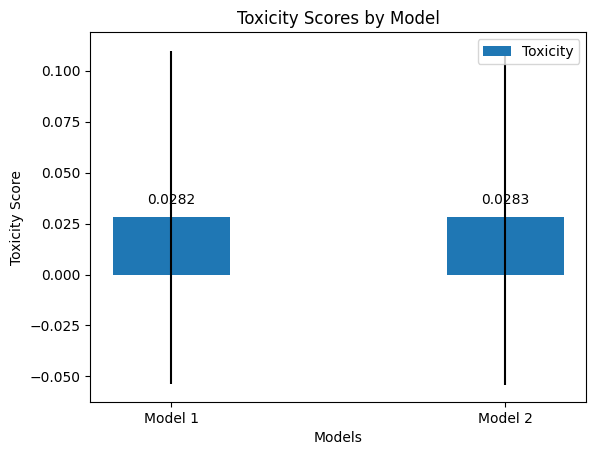

In [1]:
import matplotlib.pyplot as plt
import numpy as np
mean_scores = [0.028158942559879507, 0.02827893813632545]
std_scores = [0.08178810660198951, 0.08244852662578633]
labels = ['Model 1', 'Model 2']
x = np.arange(len(labels)) 
width = 0.35  
fig, ax = plt.subplots()
bars = ax.bar(x, mean_scores, width, yerr=std_scores, label='Toxicity')
ax.set_xlabel('Models')
ax.set_ylabel('Toxicity Score')
ax.set_title('Toxicity Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, round(yval, 4), ha='center', va='bottom')
plt.show()


### References 

1.	https://huggingface.co/docs/transformers/en/model_doc/flan-t5
2.	https://medium.com/@eren9677/text-summarization-387836c9e178
3.	https://huggingface.co/spaces/evaluate-metric/rouge
4.	https://www.promptingguide.ai/techniques/fewshot
5.	https://github.com/philschmid/deep-learning-pytorch-huggingface/blob/main/training/peft-flan-t5-int8-summarization.ipynb
6.	https://www.kaggle.com/code/paultimothymooney/fine-tune-flan-t5-with-peft-lora-deeplearning-ai
